<a href="https://colab.research.google.com/github/loverzbs/Planificacion-de-tareas-con-algoritmos-geneticos/blob/main/ProyectoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Librerías


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import copy
import math

#Parámetros del probmema

In [ ]:
trabajos = [
    [1, 3, 4],
    [0, 2, 4],
    [0, 1, 2, 3, 4],
    [3, 4],
    [1, 3],
    [0, 1, 3, 4]
]

politicas = ["FIFO", "LTP", "STP", "RRFIFO", "RRLTP", "RRECA"]
trabajos1D = [x+1 for sublist in trabajos for x in sublist]

trabajo_por_indice = []
for t, ops in enumerate(trabajos):
  for _ in ops:
    trabajo_por_indice.append(t)

tam_pob = 10
num_generaciones = 100
tam = sum(len(lista) for lista in trabajos)
n_maq = 4
n_trabajos = len(trabajos)

politicas_indices = [
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
    [13, 14, 15, 10, 11, 12, 1, 2, 3, 4, 5, 18, 19, 16, 17, 6, 7, 8, 9],
    [5, 6, 7, 8, 9, 10, 15, 16, 17, 18, 19, 1, 2, 3, 4, 11, 12, 13, 14],
    [1, 7, 13, 2, 8, 14, 3, 9, 15, 17, 19, 4, 10, 5, 11, 6, 12, 16, 18],
    [4, 10, 16, 3, 9, 15, 1, 7, 13, 17, 19, 6, 12, 5, 11, 2, 8, 14, 18],
    [4, 10, 14, 3, 9, 13, 6, 12, 16, 18, 19, 1, 7, 2, 8, 5, 11, 15, 17]
]

In [ ]:
def graficar_gantt(politica_cromosoma, df_tiempos, politica_idx):

    tiemposTrabajos = np.zeros(n_trabajos)
    tiemposMaquinas = np.zeros(n_maq)
    maquinas_asignadas = [[] for _ in range(n_maq)] # Lista para almacenar las tareas asignadas a cada máquina

    if politica_idx >= len(politicas_indices):
        print(f"Error: Índice de política {politica_idx} fuera de rango.")
        return

    indices = politicas_indices[politica_idx]
    nombre_politica = politicas[politica_idx]

    # Itera sobre cada operación global indexada en la política
    for op_global_1_based in indices:
        op_global_idx = op_global_1_based - 1

        if op_global_idx >= len(trabajos1D):
            continue

        op_id_1_based = trabajos1D[op_global_idx]

        if op_global_idx >= len(politica_cromosoma):
            continue

        maq_int = int(politica_cromosoma[op_global_idx])

        if maq_int < 1 or maq_int > n_maq:
            continue

        maq = f'm{maq_int}'

        if op_global_idx >= len(trabajo_por_indice):
            continue
        trabajo_actual = trabajo_por_indice[op_global_idx]

        if trabajo_actual >= len(tiemposTrabajos):
            continue

        if op_id_1_based in df_tiempos.index:
            t = df_tiempos.at[op_id_1_based, maq]
        else:
            continue

        inicio = max(tiemposTrabajos[trabajo_actual], tiemposMaquinas[maq_int-1])
        final = inicio + t
        tiemposTrabajos[trabajo_actual] = final
        tiemposMaquinas[maq_int-1] = final

        # Almacena la información de la tarea para el Gantt
        maquinas_asignadas[maq_int-1].append({
            'tarea': f'Trabajo {trabajo_actual + 1} - Op {op_id_1_based} ({nombre_politica})',
            'inicio': inicio,
            'fin': final
        })

    # Graficar el diagrama de Gantt
    fig, ax = plt.subplots(figsize=(12, 6))

    colores_tareas = plt.cm.get_cmap('tab10', n_trabajos) # Colores distintos por trabajo

    for maq_idx, tareas_maq in enumerate(maquinas_asignadas):
        for tarea_info in tareas_maq:
            # Extract job number for consistent coloring
            trabajo_str = tarea_info['tarea'].split('-')[0].strip()
            # Use a try-except block to safely convert to int, default to 0 if fails
            try:
                trabajo_numero = int(trabajo_str.split(' ')[1]) - 1
            except (ValueError, IndexError):
                trabajo_numero = 0 # Default to first color if parsing fails

            ax.barh(f'Máquina {maq_idx + 1}', tarea_info['fin'] - tarea_info['inicio'],
                    left=tarea_info['inicio'], height=0.5,
                    color=colores_tareas(trabajo_numero),
                    edgecolor='black')
            # Agregar texto con el nombre de la tarea
            ax.text(tarea_info['inicio'] + (tarea_info['fin'] - tarea_info['inicio']) / 2,
                    f'Máquina {maq_idx + 1}',
                    tarea_info['tarea'],
                    va='center', ha='center', color='white', fontsize=8)


    ax.set_xlabel('Tiempo')
    ax.set_ylabel('Máquina')
    ax.set_title(f'Diagrama de Gantt - {nombre_politica}')
    ax.grid(axis='x', linestyle='--')
    plt.tight_layout()
    plt.show()

#Dominancia de individuos segun si ND y DC

In [ ]:
def domina(p,q):#p y q son puntos de la forma [x,y]

        no_peor = np.all(np.array(p) <= np.array(q))

        mejor_en_alguno = np.any(np.array(p) < np.array(q))

        return no_peor and mejor_en_alguno

##Cruza uniforme de poliploides

In [ ]:
def cruza_uniforme_poliploide(individuo1, individuo2, probabilidad=0.5):

    hijo1 = np.zeros(shape= [6,tam], dtype=int)
    hijo2 = np.zeros(shape= [6,tam], dtype=int)

    for i in range(tam):
        if random.random() > probabilidad :
            for j in range(6):
                hijo1[j][i] = int(individuo2[j][i])
                hijo2[j][i] = int(individuo1[j][i])
        else:
            for j in range(6):
                hijo1[j][i] = int(individuo1[j][i])
                hijo2[j][i] = int(individuo2[j][i])

    return hijo1, hijo2

In [ ]:
def obtener_hijos(poblacion, probabilidad_de_cruza=1):
    hijos = []
    iteraciones = len(poblacion) // 2
    for _ in range(iteraciones):
        if(random.random() > probabilidad_de_cruza):
            padre1, padre2 = random.sample(poblacion, 2)
            cromosomaP1 = padre1.cromosoma
            cromosomaP2 = padre2.cromosoma
            cromosomaH1, cromosomaH2 = cruza_uniforme_poliploide(cromosomaP1, cromosomaP2)
            hijo1 = Individuo(cromosomaH1)
            hijo2 = Individuo(cromosomaH2)
            hijos.append(hijo1)
            hijos.append(hijo2)
    return hijos

##Operadores de mutación

In [ ]:
def mutacion_intercromosoma(individuo):
  nuevo_indiv = copy.deepcopy(individuo.cromosoma)
  i, j = random.sample(range(nuevo_indiv.shape[0]), 2)
  nuevo_indiv[[i, j]] = nuevo_indiv[[j, i]]
  return nuevo_indiv.astype(int)

In [ ]:
def mutacion_reciproca(individuo, probabilidad=0.5):
  nuevo_indiv = copy.deepcopy(individuo.cromosoma)
  for idx in range(nuevo_indiv.shape[0]):
    if random.random() < probabilidad:
      crom = nuevo_indiv[idx]
      n = len(crom)
      num_intercambios = random.randint(1,2)
      for _ in range(num_intercambios):
        i, j = random.sample(range(n), 2)
        crom[i], crom[j] = crom[j], crom[i]
  return nuevo_indiv.astype(int)

In [ ]:
def mutacion_desplazamiento(individuo, probabilidad=0.3):
  nuevo_indiv = copy.deepcopy(individuo.cromosoma)
  for idx in range(nuevo_indiv.shape[0]):
    if random.random() < probabilidad:
      crom = nuevo_indiv[idx]
      n = len(crom)
      i, j = sorted(random.sample(range(n), 2))
      segmento = crom[i:j+1]
      resto = np.concatenate((crom[:i], crom[j+1:]))
      nueva_pos = random.randint(0, len(resto))
      nuevo_crom = np.concatenate((resto[:nueva_pos], segmento, resto[nueva_pos:]))
      nuevo_indiv[idx] = nuevo_crom
  return nuevo_indiv.astype(int)

In [ ]:
def mutar_poblacion(individuos, p_inter_cromosomica=33, p_reciproco=33, p_desplazamiento=34):
    individuos_mutados = []
    probabilidades = [p_inter_cromosomica, p_reciproco, p_desplazamiento]
    mutaciones = [mutacion_intercromosoma, mutacion_reciproca, mutacion_desplazamiento]
    for individuo in individuos:
        funcion_mutacion = random.choices(mutaciones, weights=probabilidades, k=1)[0]
        cromosoma_mutado = funcion_mutacion(individuo)
        individuo_mutado = Individuo(cromosoma_mutado)
        individuos_mutados.append(individuo_mutado)
    return individuos_mutados

##Torneo

In [ ]:
def torneo_binario(individuo1, individuo2):
    i1 = copy.deepcopy(individuo1)
    i2 = copy.deepcopy(individuo2)
    supercromosoma = []
    for i in range(len(i1.cromosoma)):
        if i1.nd[i] < i2.nd[i]:
            supercromosoma.append(i1.cromosoma[i])
        elif i1.nd[i] > i2.nd[i]:
            supercromosoma.append(i2.cromosoma[i])
        else:
            if i1.dc[i] > i2.dc[i]:
                supercromosoma.append(i1.cromosoma[i])
            else:
                supercromosoma.append(i2.cromosoma[i])
    return Individuo(supercromosoma)

In [ ]:
def ejecutar_torneo(poblacion):
    nueva_poblacion = []
    iteraciones = len(poblacion)//2
    for _ in range(iteraciones):
        individuo1, individuo2 = random.sample(poblacion, 2)
        superindividuo = torneo_binario(individuo1, individuo2)
        nueva_poblacion.append(superindividuo)
    return nueva_poblacion

##Clase individuo


In [ ]:
class Individuo:

    def __init__(self, cromosoma=None):
        if cromosoma is None:
            self.cromosoma = self.inicializar_cromosoma()
        else:
            self.cromosoma = cromosoma
        self.energia = []
        self.tiempo = []
        self.nd = np.zeros(6)
        self.dc = np.zeros(6)
        self.id = None

    def inicializar_cromosoma(self):
        return np.random.randint(1, n_maq + 1, size=(6, tam))


    def imprimir_individuo(self):

        for politica in self.cromosoma:
            print(politica)

    def calcular_energia(self, df_energia):
        self.energia = []
        for politica in self.cromosoma:
            total_energia_politica = 0
            for k, gen in enumerate(politica):
                op_global_idx = k

                if op_global_idx >= len(trabajos1D):
                    continue

                op_id_1_based = trabajos1D[op_global_idx]

                maq_int = int(gen) # máquina asignada por el cromosoma

                if maq_int < 1 or maq_int > n_maq:
                    continue

                columna = f"m{maq_int}"

                if op_id_1_based in df_energia.index: # verifica que exista el índice
                    total_energia_politica += df_energia.at[op_id_1_based, columna]
                else:
                    pass

            self.energia.append(total_energia_politica)

    def calcular_tiempo(self, df_tiempos):
        self.tiempo = []
        for idx_pol, politica in enumerate(self.cromosoma):
            if idx_pol >= len(politicas_indices):
                continue

            indices = politicas_indices[idx_pol]
            tiemposTrabajos = np.zeros(n_trabajos)
            tiemposMaquinas = np.zeros(n_maq)

            for op_global_1_based in indices:
                op_global_idx = op_global_1_based - 1

                if op_global_idx >= len(trabajos1D):
                    continue

                op_id_1_based = trabajos1D[op_global_idx]

                if op_global_idx >= len(politica):
                    continue
                maq_int = int(politica[op_global_idx]) # máquina asignada por el cromosoma

                if maq_int < 1 or maq_int > n_maq:
                    continue

                maq = f'm{maq_int}'

                if op_global_idx >= len(trabajo_por_indice):
                    continue
                trabajo_actual = trabajo_por_indice[op_global_idx]

                if trabajo_actual >= len(tiemposTrabajos):
                    continue

                if op_id_1_based in df_tiempos.index:
                    t = df_tiempos.at[op_id_1_based, maq]
                else:
                    continue # salta si la operación no se encontró
                inicio = max(tiemposTrabajos[trabajo_actual], tiemposMaquinas[maq_int-1])
                final = inicio + t
                tiemposTrabajos[trabajo_actual] = final
                tiemposMaquinas[maq_int-1] = final

            self.tiempo.append(max(tiemposMaquinas))

##Clase poblacion


In [ ]:
class Poblacion:

    def __init__(self, tam):
        semilla = 42
        random.seed(semilla)
        np.random.seed(semilla)
        self.tamaño= tam
        self.individuos = [Individuo() for _ in range(tam)]
        for i,individuo in enumerate(self.individuos):
            individuo.inicializar_cromosoma()
            individuo.id = i

    def imprimir_poblacion(self):

        for i,individuo in enumerate(self.individuos):
            print(f"individuo {i}")
            individuo.imprimir_individuo()

    def evaluarEnergia(self, df_energia):
        for individuo in self.individuos:
            individuo.calcular_energia(df_energia)

    def evaluarTiempo(self, df_tiempos):
        for individuo in self.individuos:
            individuo.calcular_tiempo(df_tiempos)

    def ver_energias(self):
        for i,individuo in enumerate(self.individuos):
            print(f"Energia del individuo {i}")
            lista = []
            for valor in individuo.energia:
                lista.append(float(valor))

            print(list(zip(politicas, lista)))

    def ver_tiempos(self):
        for i,individuo in enumerate(self.individuos):
            print(f"Tiempo del individuo {i}")
            lista = []
            for valor in individuo.tiempo:
                lista.append(float(valor))

            print(list(zip(politicas, lista)))

    def pareto_sorting(self):

        frentes_por_politica = []

        for politica_idx in range(6):  # POR CADA POLÍTICA

            lista_de_energias = [individuo.energia[politica_idx] for individuo in self.individuos]
            lista_de_tiempos = [individuo.tiempo[politica_idx] for individuo in self.individuos]
            puntos = [[lista_de_energias[j], lista_de_tiempos[j]] for j in range(self.tamaño)]

            # Inicialización
            S = [[] for _ in range(len(puntos))]  # Conjuntos dominados por cada punto
            n = [0 for _ in range(len(puntos))]   # Cuántos dominan a este
            rank = [0 for _ in range(len(puntos))]

            frentes = [[]]  # Primer frente vacío

            # Calcular dominancia
            for p in range(len(puntos)):
                for q in range(len(puntos)):
                    if domina(puntos[p], puntos[q]):
                        S[p].append(q)
                    elif domina(puntos[q], puntos[p]):
                        n[p] += 1
                if n[p] == 0:
                    rank[p] = 0
                    frentes[0].append(p)

            # Construir los siguientes frentes
            i = 0
            while len(frentes[i]) > 0:
                Q = []
                for p in frentes[i]:
                    for q in S[p]:
                        n[q] -= 1
                        if n[q] == 0:
                            rank[q] = i + 1
                            Q.append(q)
                i += 1
                frentes.append(Q)

            # Quitar último frente vacío
            frentes = [f for f in frentes if len(f) > 0]

            frentes_por_politica.append(frentes)

            # Asignar nivel de dominancia (nd) correctamente
            for nivel, frente_n in enumerate(frentes):
                for idx_individuo in frente_n:
                    self.individuos[idx_individuo].nd[politica_idx] = nivel+1

        return frentes_por_politica

    def distancia_crowding(self, frentes_por_politica):

        for politica_idx in range(6):
            frentes = frentes_por_politica[politica_idx]
            for frente in frentes:
                if len(frente) <= 2:
                    for idx_individuo in frente:
                        self.individuos[idx_individuo].dc[politica_idx] = float('inf')
                else:
                    puntos_frente = [[self.individuos[idx].energia[politica_idx], self.individuos[idx].tiempo[politica_idx]] for idx in frente]

                    sorted_indices_by_energia = sorted(range(len(puntos_frente)), key=lambda k: puntos_frente[k][0])
                    sorted_frente_energia = [frente[i] for i in sorted_indices_by_energia]

                    sorted_indices_by_tiempo = sorted(range(len(puntos_frente)), key=lambda k: puntos_frente[k][1])
                    sorted_frente_tiempo = [frente[i] for i in sorted_indices_by_tiempo]


                    for idx_individuo in frente:
                        self.individuos[idx_individuo].dc[politica_idx] = 0.0

                    max_energia = puntos_frente[sorted_indices_by_energia[-1]][0]
                    min_energia = puntos_frente[sorted_indices_by_energia[0]][0]
                    max_tiempo = puntos_frente[sorted_indices_by_tiempo[-1]][1]
                    min_tiempo = puntos_frente[sorted_indices_by_tiempo[0]][1]

                    energia_range = max_energia - min_energia if max_energia != min_energia else 1.0
                    tiempo_range = max_tiempo - min_tiempo if max_tiempo != min_tiempo else 1.0


                    for i in range(1, len(sorted_frente_energia) - 1):
                        idx_actual = sorted_frente_energia[i]
                        idx_anterior_energia = sorted_frente_energia[i-1]
                        idx_siguiente_energia = sorted_frente_energia[i+1]

                        distancia_energia = (self.individuos[idx_siguiente_energia].energia[politica_idx] - self.individuos[idx_anterior_energia].energia[politica_idx]) / energia_range
                        self.individuos[idx_actual].dc[politica_idx] += distancia_energia

                    for i in range(1, len(sorted_frente_tiempo) - 1):
                        idx_actual = sorted_frente_tiempo[i]
                        idx_anterior_tiempo = sorted_frente_tiempo[i-1]
                        idx_siguiente_tiempo = sorted_frente_tiempo[i+1]

                        distancia_tiempo = (self.individuos[idx_siguiente_tiempo].tiempo[politica_idx] - self.individuos[idx_anterior_tiempo].tiempo[politica_idx]) / tiempo_range
                        self.individuos[idx_actual].dc[politica_idx] += distancia_tiempo


    def sig_generacion(self, df_energia, df_tiempos):
        hijos = mutar_poblacion(obtener_hijos(self.individuos))
        self.individuos.extend(hijos)
        self.tamaño = len(self.individuos)
        self.evaluarEnergia(df_energia)
        self.evaluarTiempo(df_tiempos)
        frentes = self.pareto_sorting()
        self.distancia_crowding(frentes)
        self.individuos = ejecutar_torneo(self.individuos)
        self.tamaño = len(self.individuos)
        self.evaluarEnergia(df_energia)
        self.evaluarTiempo(df_tiempos)
        self.pareto_sorting()


    def graficarfrentes(self):

        colores = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'magenta']

        for p in range(6):  # una gráfica por política

            x = np.array([individuo.energia[p] for individuo in self.individuos])
            y = np.array([individuo.tiempo[p] for individuo in self.individuos])
            niveles = np.array([individuo.nd[p] for individuo in self.individuos])  # nivel de Pareto de cada individuo

            plt.figure(figsize=(6, 4))
            for idx in range(len(x)):
                nivel = int(niveles[idx])
                color = colores[nivel % len(colores)]
                plt.scatter(x[idx], y[idx], color=color, label=f"Frente {nivel}" if f"Frente {nivel}" not in plt.gca().get_legend_handles_labels()[1] else "")

            plt.xlabel("Energía")
            plt.ylabel("Tiempo")
            plt.title(f"Frentes de Pareto - {politicas[p]}")
            plt.legend(title="Frentes", bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True)
            plt.tight_layout()
            plt.show()

#MAIN

In [ ]:
!pip install pymoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.9 MB/s eta 0:00:00


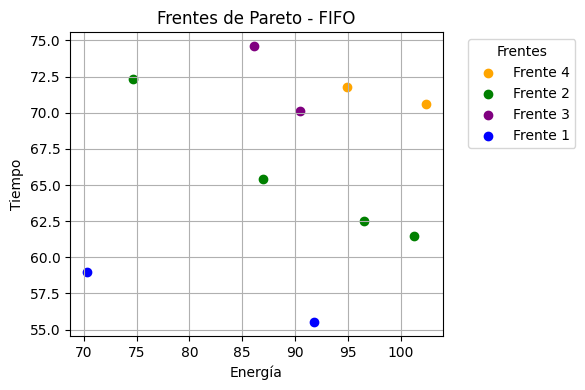

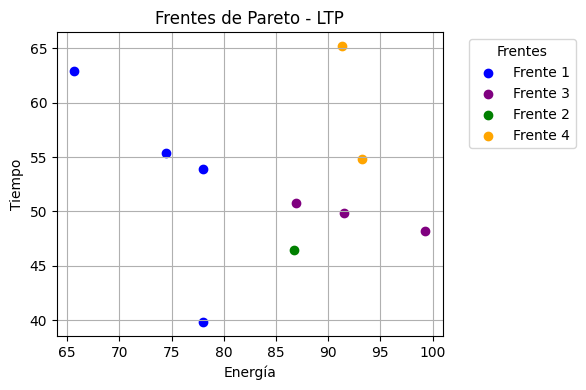

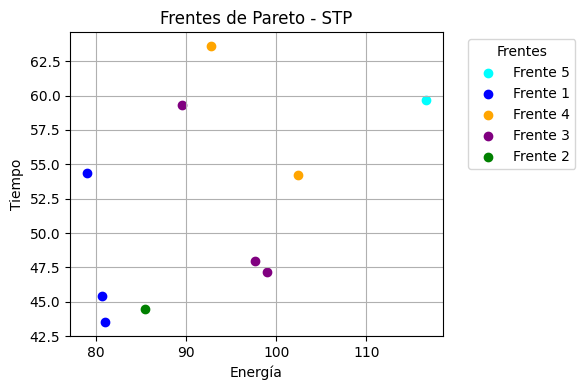

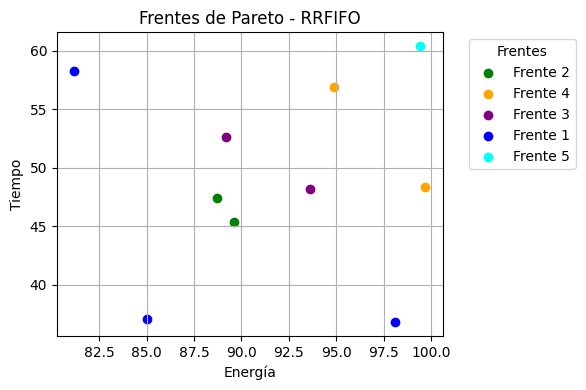

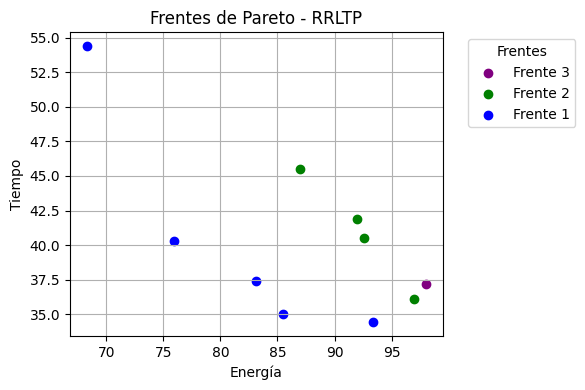

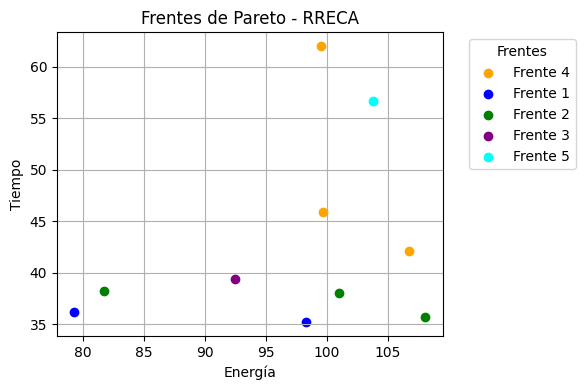

Generación 0
individuo 0
[3 4 1 3 3 4 1 1 3 2 3 3 3 3 4 1 4 4 4]
[3 2 1 2 4 4 2 2 2 4 4 1 1 4 2 2 1 4 1]
[1 3 3 3 2 4 4 4 4 3 2 2 3 2 3 4 3 4 4]
[1 3 1 3 3 1 1 3 2 4 1 4 2 2 2 1 2 1 2]
[4 4 3 4 3 4 1 4 3 3 2 1 4 2 4 4 2 2 2]
[2 2 4 2 1 3 2 2 4 2 2 2 4 2 3 4 3 4 2]
individuo 1
[3 4 1 2 4 1 4 1 2 3 1 4 2 1 4 4 4 1 1]
[1 3 1 1 1 3 1 4 1 4 4 4 3 3 3 1 4 3 3]
[1 3 1 2 3 2 1 4 3 1 4 4 2 1 4 3 3 2 4]
[1 3 4 4 2 3 3 1 3 1 3 2 3 1 1 2 3 3 2]
[3 3 1 3 3 2 2 4 1 3 3 4 3 1 4 1 4 4 2]
[1 3 3 1 3 3 1 4 1 4 3 3 3 2 4 2 2 1 2]
individuo 2
[1 1 2 4 4 4 4 4 2 2 3 4 2 3 4 1 3 2 1]
[1 1 3 2 1 4 1 1 3 3 2 4 3 1 2 1 1 3 2]
[4 4 3 3 2 4 4 4 1 4 1 2 1 2 4 4 2 3 2]
[3 1 1 1 4 1 3 1 2 2 4 2 3 1 4 1 1 3 2]
[2 1 4 2 4 2 4 3 4 3 3 4 3 1 3 2 4 1 4]
[2 2 2 3 3 4 4 1 1 4 3 2 4 1 3 4 4 3 4]
individuo 3
[3 2 3 3 3 4 4 3 4 1 1 4 4 3 2 4 1 3 4]
[1 1 2 3 3 2 2 3 3 4 4 2 4 1 4 4 1 2 1]
[4 2 4 1 1 4 3 3 1 1 3 3 4 4 3 4 4 2 4]
[1 4 4 3 1 4 4 2 4 4 2 3 4 2 1 3 1 1 2]
[4 2 2 2 2 3 4 1 1 4 1 4 1 2 1 4 4 4 4]
[4 3 3 1 4 1 4 4 3 

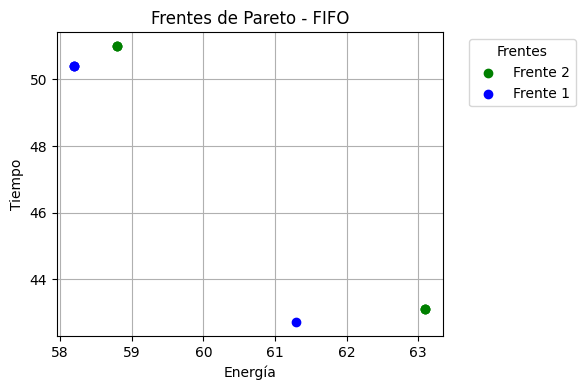

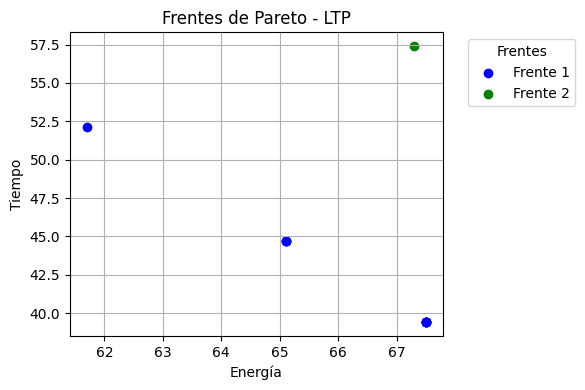

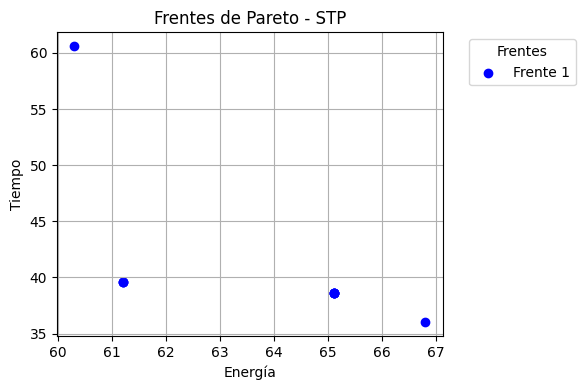

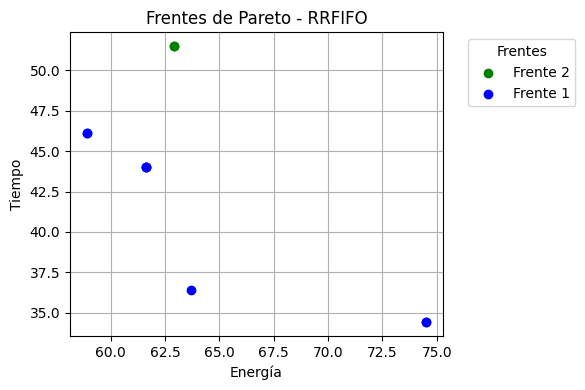

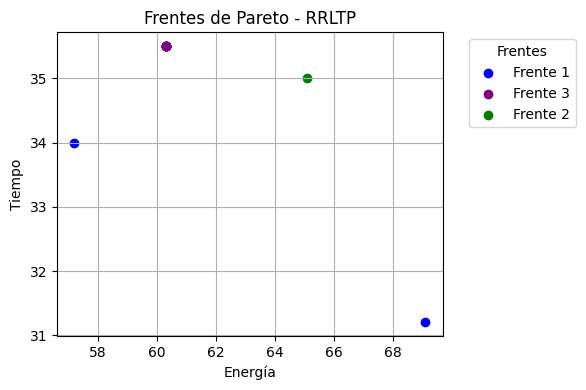

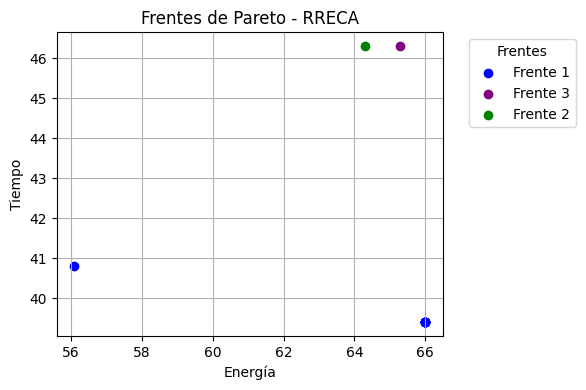

individuo 0
[4 1 1 2 4 4 2 2 2 4 4 3 2 1 4 2 1 1 1]
[1 1 1 3 3 2 2 4 1 1 3 4 4 1 4 4 1 2 1]
[1 1 1 3 4 4 2 2 2 4 4 2 1 1 4 2 1 4 1]
[1 2 1 1 4 4 2 2 2 4 4 1 1 1 2 2 1 4 1]
[3 1 1 3 3 4 2 2 3 1 4 2 2 1 4 2 1 4 4]
[1 2 1 1 3 1 2 1 2 4 1 4 4 2 4 2 4 3 1]
individuo 1
[1 1 1 2 4 4 2 2 2 4 4 2 2 1 4 2 1 1 1]
[3 1 1 3 3 4 2 2 3 1 4 2 1 1 4 2 1 4 4]
[3 1 1 3 3 4 2 2 3 1 4 2 1 1 4 2 1 4 4]
[4 2 1 1 4 3 2 1 3 4 1 1 1 1 2 2 1 4 1]
[1 1 1 3 4 4 2 2 2 4 4 2 1 1 4 2 1 4 1]
[1 2 1 1 3 1 2 1 2 4 1 4 4 2 4 2 4 3 1]
individuo 2
[1 1 1 2 4 4 2 2 2 4 4 2 2 1 4 2 1 4 1]
[1 1 1 3 3 2 2 4 1 1 3 4 4 1 4 4 2 1 1]
[1 1 1 3 3 4 2 2 1 1 4 2 2 1 4 2 1 4 4]
[1 2 1 1 4 4 2 1 2 4 1 1 1 1 2 2 4 4 1]
[1 1 1 3 4 4 2 1 2 4 4 2 1 2 4 2 1 4 1]
[1 1 1 2 3 1 2 1 3 4 1 4 4 2 4 2 4 3 1]
individuo 3
[4 1 1 2 4 4 2 2 2 4 4 3 2 1 4 2 1 1 1]
[1 1 1 3 3 2 2 2 1 1 3 2 1 1 4 2 1 4 1]
[3 1 1 3 3 4 2 2 3 1 4 2 1 1 4 2 1 4 4]
[4 2 1 1 4 3 3 1 3 4 1 1 1 2 2 2 4 4 4]
[1 1 1 3 4 4 2 2 2 4 4 2 1 1 4 2 1 4 1]
[1 2 1 1 3 1 2 1 2 4 1 4 4 2 4 2

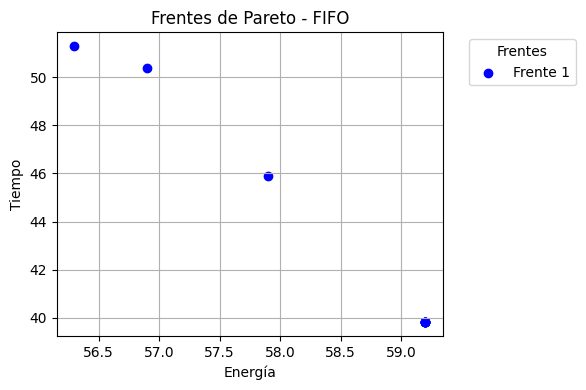

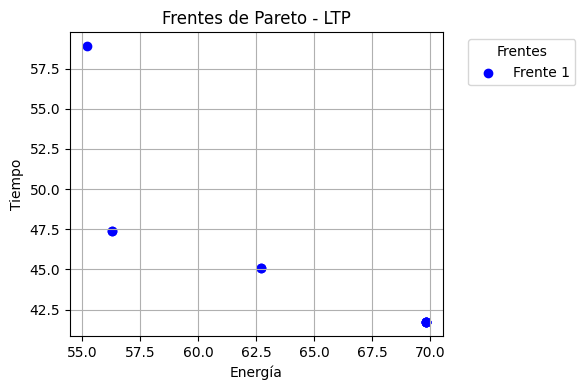

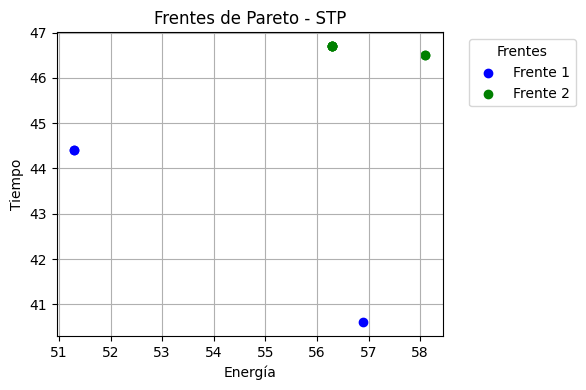

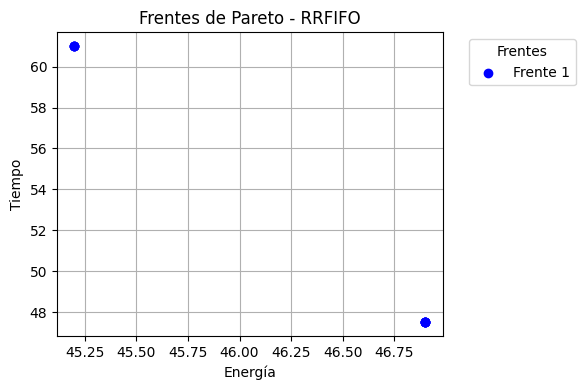

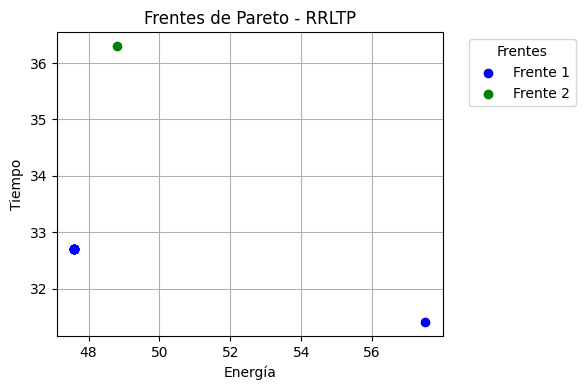

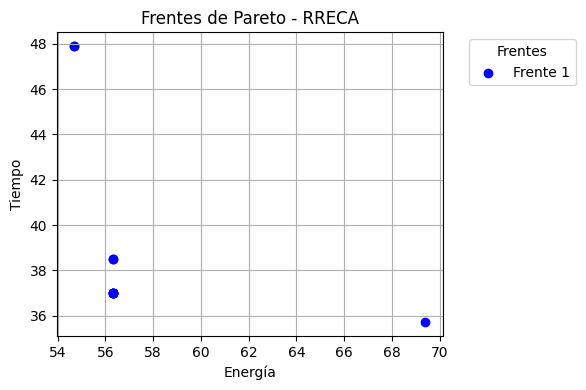

individuo 0
[1 1 1 2 4 4 2 2 1 4 4 2 2 1 4 1 1 1 1]
[3 1 1 3 3 4 2 4 1 1 4 4 4 1 4 2 1 1 1]
[1 1 1 3 3 4 2 4 1 4 4 4 4 1 4 2 1 1 1]
[4 1 1 2 3 1 2 2 1 4 1 1 1 1 1 2 1 1 4]
[1 1 1 2 3 4 2 2 3 4 1 4 1 1 4 2 1 4 1]
[3 1 1 3 3 4 2 4 1 1 4 4 4 1 4 2 1 1 1]
individuo 1
[3 4 1 3 3 4 2 4 1 1 4 1 4 1 4 2 1 1 1]
[3 1 1 3 3 4 2 4 1 1 4 4 4 1 4 4 1 1 1]
[3 1 1 3 3 4 2 4 1 1 4 4 4 1 4 2 1 1 1]
[4 1 1 2 3 1 2 2 1 4 1 1 1 1 1 2 1 1 4]
[1 1 1 2 3 4 2 2 3 4 1 4 1 1 4 2 1 4 1]
[3 1 1 3 3 4 2 4 1 4 4 1 4 1 4 2 1 1 1]
individuo 2
[1 1 1 2 3 4 2 2 2 1 4 2 2 1 4 2 1 1 1]
[3 4 1 3 3 1 2 4 1 1 4 4 4 1 4 2 1 1 1]
[3 1 1 3 3 4 2 4 1 1 4 4 4 1 4 2 1 1 1]
[1 1 1 2 3 1 2 2 1 4 1 1 4 1 1 2 4 1 4]
[1 1 1 2 3 4 2 2 3 4 1 4 1 1 4 2 1 4 1]
[3 1 1 1 3 4 2 4 1 1 4 1 4 1 4 2 1 1 1]
individuo 3
[1 1 1 2 4 4 2 2 1 4 4 2 2 1 4 1 1 1 1]
[3 1 1 3 3 4 2 4 1 1 4 4 4 1 4 4 1 1 1]
[1 1 1 3 3 4 2 4 1 4 4 4 4 1 4 2 1 1 1]
[4 1 1 2 3 1 2 2 1 4 1 1 1 1 1 2 4 1 4]
[1 1 1 2 3 4 2 2 3 4 1 4 1 1 4 2 1 4 1]
[3 1 1 3 3 4 2 4 1 4 4 1 4 1 4 2

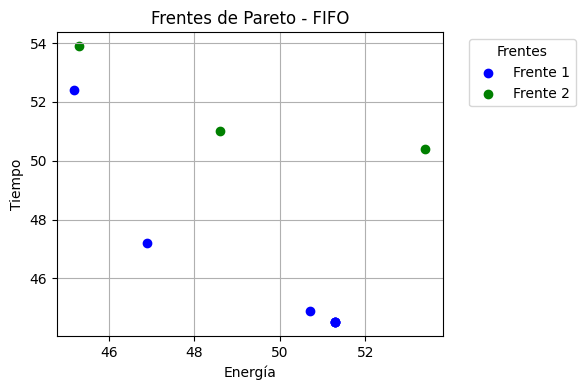

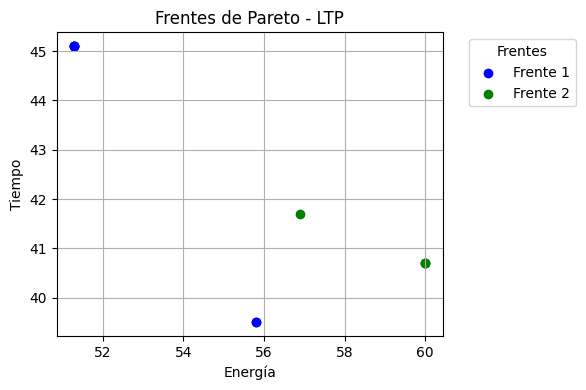

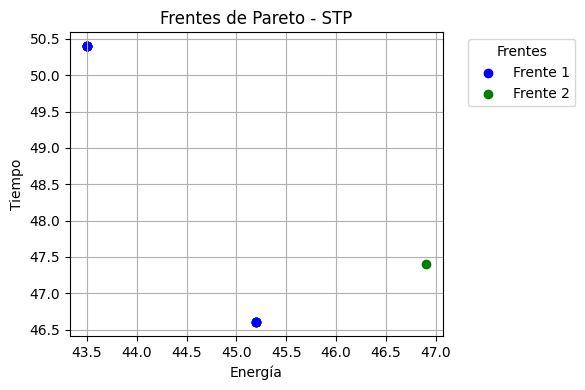

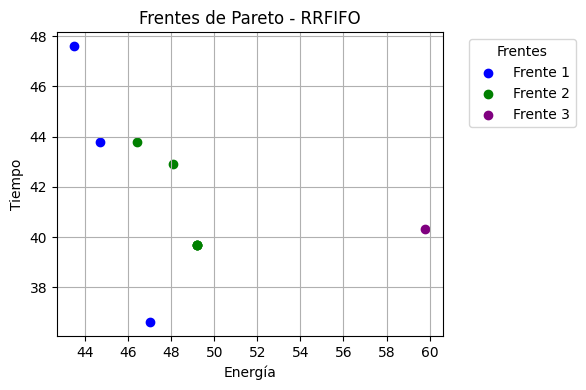

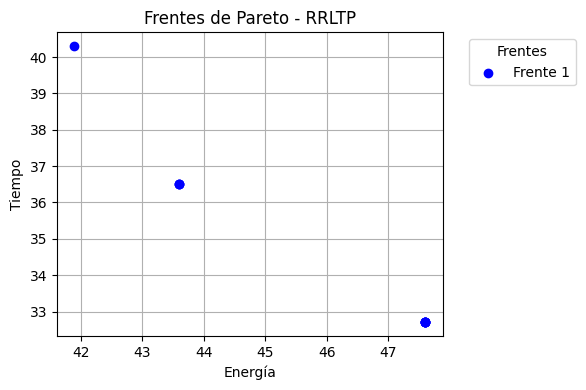

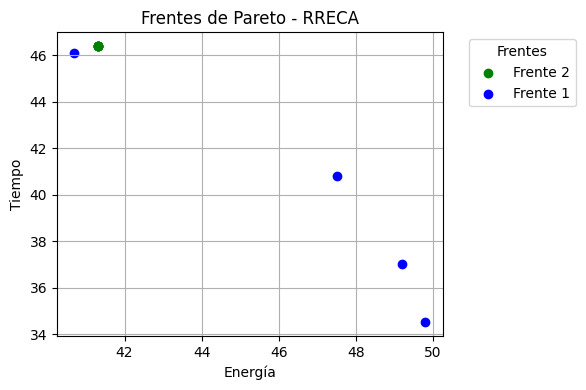

individuo 0
[1 1 1 2 3 4 2 4 1 1 1 4 4 1 4 2 4 1 1]
[1 1 1 3 3 4 2 4 1 4 4 4 4 1 4 2 1 1 1]
[1 1 1 2 3 1 2 4 1 1 1 4 4 1 4 2 4 1 1]
[1 1 1 2 3 4 2 4 1 1 1 4 1 1 4 2 4 1 1]
[1 1 1 2 3 4 2 2 3 4 1 4 1 1 4 2 1 4 1]
[1 1 1 2 3 1 2 1 3 4 1 1 1 1 4 2 1 4 1]
individuo 1
[1 1 1 2 3 4 2 2 1 1 4 4 4 1 1 2 1 1 1]
[1 1 1 3 3 4 2 4 1 4 4 4 4 1 4 2 1 1 1]
[1 1 1 2 3 1 2 4 1 1 4 4 4 1 4 2 4 1 1]
[4 4 1 2 3 1 2 2 1 4 4 4 1 1 4 2 1 1 1]
[1 1 1 2 3 1 2 1 3 4 1 4 1 1 4 2 1 4 1]
[1 1 1 2 3 1 2 1 3 4 1 1 1 1 4 2 1 4 1]
individuo 2
[1 1 1 2 4 1 2 2 3 1 1 2 1 1 1 2 4 4 1]
[1 2 1 3 3 4 2 4 1 4 4 4 4 1 4 1 1 1 1]
[1 1 1 2 3 1 2 4 1 1 1 4 4 1 4 2 4 1 1]
[4 4 1 2 3 1 2 2 1 4 4 1 1 1 1 2 4 1 4]
[1 1 1 2 3 4 2 2 3 4 1 4 1 1 4 2 1 4 1]
[1 1 1 2 3 1 2 1 3 4 1 1 1 1 4 2 1 4 1]
individuo 3
[1 1 1 2 4 4 2 4 1 1 1 4 4 1 1 2 4 1 1]
[1 1 1 3 3 4 2 4 1 4 4 4 4 1 4 1 1 1 1]
[1 1 1 2 3 1 2 4 1 1 4 4 4 1 4 2 4 1 1]
[1 4 1 2 3 4 2 2 1 4 4 4 1 1 1 2 1 1 1]
[1 1 1 2 3 4 2 2 3 4 1 4 1 1 4 2 1 4 1]
[1 1 1 2 3 1 2 1 1 4 1 4 4 1 4 2

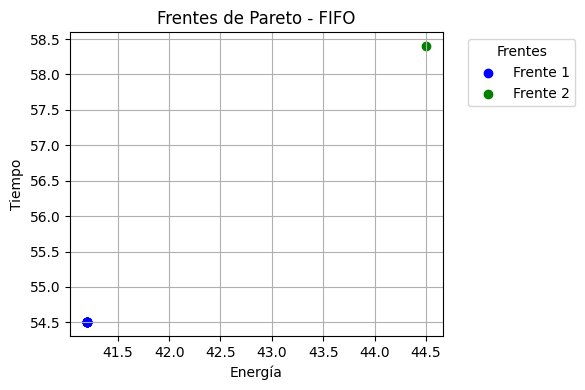

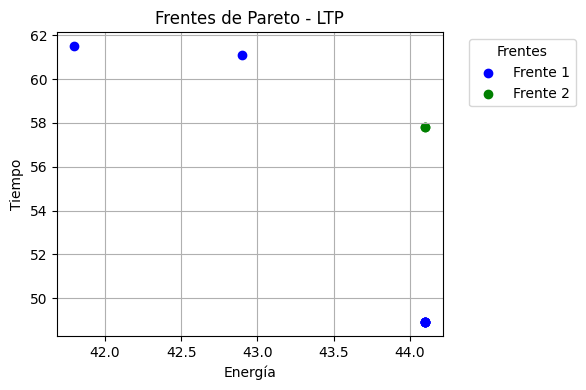

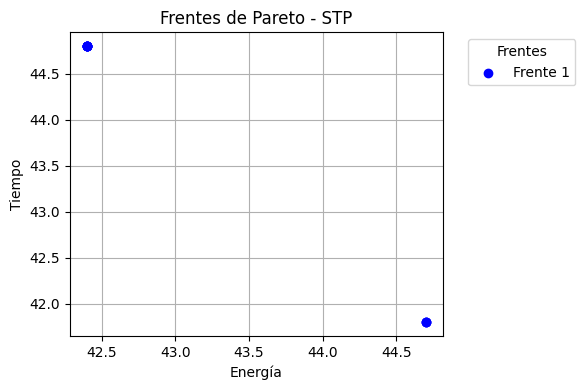

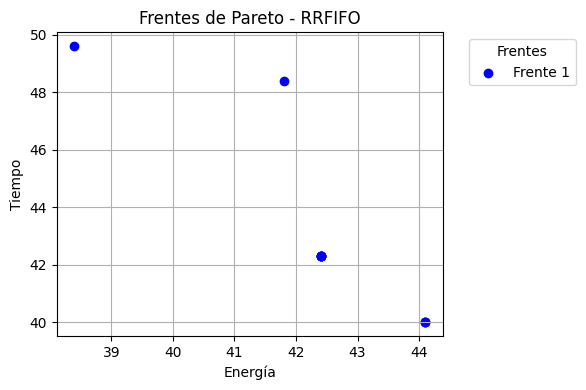

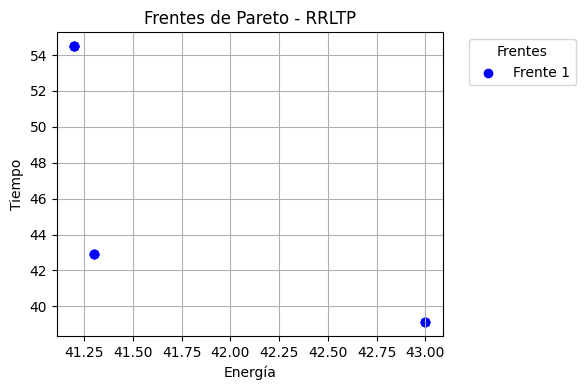

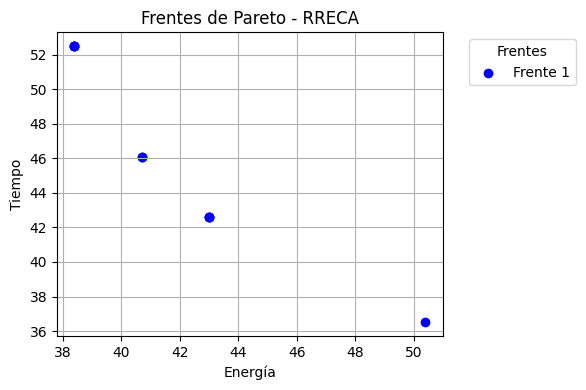

individuo 0
[1 1 1 2 3 1 2 4 1 1 1 4 1 1 1 2 4 1 1]
[1 1 1 2 3 1 2 4 1 1 4 4 1 1 1 2 4 1 1]
[1 1 1 2 3 1 2 1 3 4 1 4 4 4 4 2 1 1 1]
[1 1 1 2 1 1 2 1 1 4 1 1 1 4 4 2 1 4 1]
[1 1 1 2 3 4 2 1 1 4 1 4 1 1 4 2 1 4 1]
[1 1 1 2 3 1 2 1 1 4 1 4 4 1 4 2 1 1 1]
individuo 1
[3 1 1 2 1 1 2 4 1 1 1 4 1 1 1 2 4 1 1]
[1 1 1 2 3 1 2 4 3 1 1 4 1 1 4 2 4 1 1]
[1 1 1 2 3 1 2 1 1 4 1 4 4 4 4 2 1 1 1]
[1 4 1 2 3 1 2 4 1 4 1 4 1 1 1 2 4 1 1]
[1 1 1 2 3 1 2 1 1 1 1 4 4 1 1 2 4 1 1]
[1 1 1 2 1 1 2 1 1 4 1 1 1 4 4 2 1 4 1]
individuo 2
[1 1 1 2 3 1 2 4 1 1 1 4 1 1 1 2 4 1 1]
[1 1 1 2 3 4 2 4 1 4 4 4 1 1 4 2 1 1 1]
[1 1 1 2 3 1 2 1 3 4 1 4 4 4 4 2 1 1 1]
[1 4 1 2 3 1 2 4 1 4 1 4 1 1 1 2 4 1 1]
[1 1 1 2 3 4 2 1 1 4 1 4 1 1 4 2 4 4 1]
[1 3 1 2 3 4 2 1 3 4 1 1 1 1 4 2 1 4 1]
individuo 3
[1 1 1 2 3 1 2 4 1 1 1 4 1 1 1 2 4 1 1]
[1 1 1 2 3 1 2 1 1 4 1 4 4 4 1 2 1 1 1]
[1 1 1 2 3 1 2 1 1 4 1 4 4 4 4 2 1 1 1]
[1 4 1 2 3 1 2 4 1 4 1 4 1 1 1 2 4 1 1]
[1 1 1 2 3 1 2 1 1 1 1 4 4 1 1 2 4 1 1]
[1 1 1 2 1 1 2 1 1 4 1 1 1 4 4 2

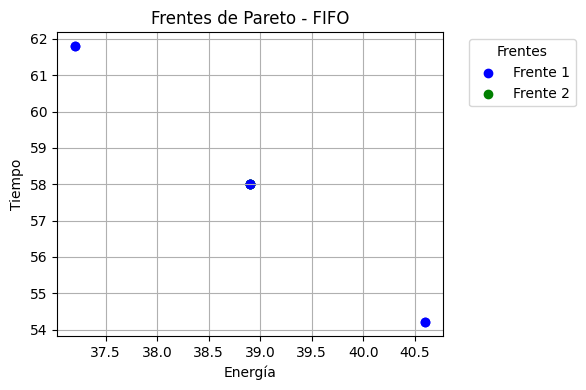

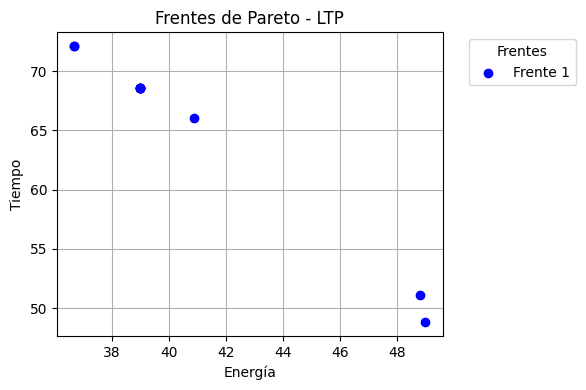

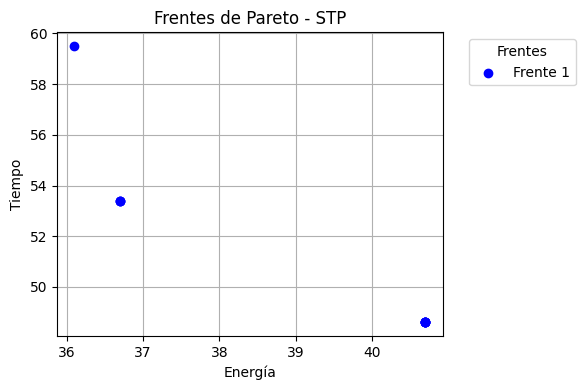

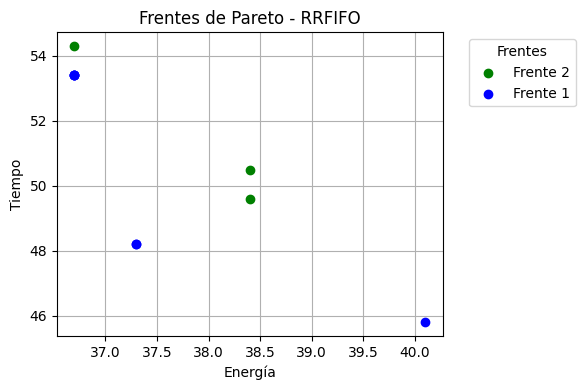

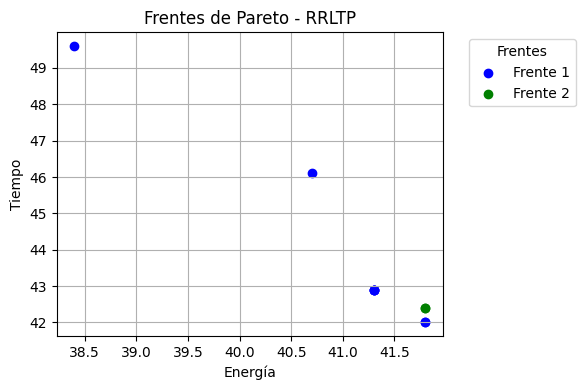

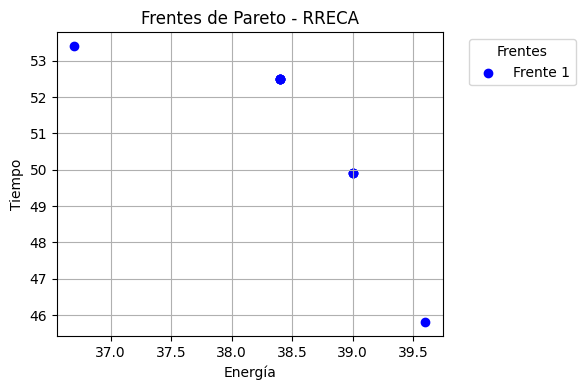

individuo 0
[1 1 4 2 1 1 2 1 1 1 1 4 1 1 1 2 4 1 1]
[1 1 1 2 3 1 2 1 1 4 1 4 1 1 4 2 1 1 1]
[1 1 1 2 1 1 2 1 1 4 1 4 1 1 4 2 1 1 1]
[1 1 1 2 1 1 2 1 1 4 1 4 1 1 1 2 4 4 1]
[1 1 1 2 3 1 2 1 1 1 1 4 1 1 4 2 4 4 1]
[1 1 1 2 1 1 2 1 1 4 1 1 1 4 4 2 1 4 1]
individuo 1
[1 1 1 2 1 1 2 1 1 1 1 4 1 1 1 2 4 1 1]
[1 1 1 2 1 1 2 1 1 4 1 4 1 1 4 2 1 1 1]
[1 1 1 2 3 1 2 1 1 4 4 4 1 1 4 2 1 1 1]
[1 4 1 2 1 1 2 1 1 1 1 4 1 1 1 2 1 4 4]
[1 1 1 2 3 1 2 1 1 4 1 4 1 1 4 2 4 4 1]
[1 1 1 2 1 1 2 1 1 4 1 1 1 4 4 2 1 4 1]
individuo 2
[1 1 4 2 1 1 2 4 1 1 1 4 1 1 1 2 4 1 1]
[1 1 1 2 1 1 2 1 1 4 1 4 1 1 4 2 1 2 1]
[1 1 1 2 3 1 2 1 1 4 4 4 1 1 4 2 1 1 1]
[1 1 1 2 1 1 2 1 1 4 1 4 1 1 4 2 1 1 1]
[1 1 1 2 1 4 2 4 1 1 1 4 1 1 4 2 4 4 1]
[1 1 1 2 1 1 2 1 1 4 1 4 1 1 4 2 1 1 1]
individuo 3
[1 1 4 2 1 1 2 1 1 1 1 4 1 1 1 2 4 1 1]
[1 1 1 2 3 1 2 1 1 4 1 4 1 1 4 2 1 1 1]
[1 1 1 2 1 1 2 1 1 4 1 4 1 1 4 2 1 1 1]
[1 1 1 2 1 1 2 1 1 4 1 4 1 1 1 2 1 4 1]
[1 1 1 2 3 1 2 1 1 4 1 4 1 1 4 2 4 4 1]
[1 1 1 2 1 1 2 1 1 4 1 1 1 4 4 2

/tmp/ipython-input-3022683041.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colores_tareas = plt.cm.get_cmap('tab10', n_trabajos) # Colores distintos por trabajo


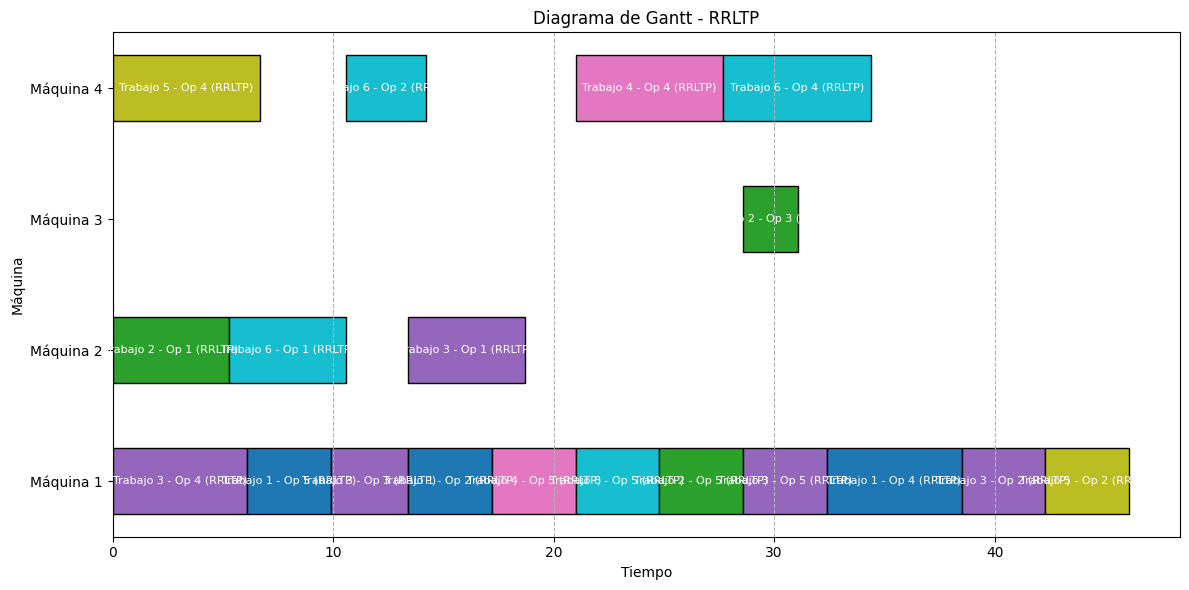

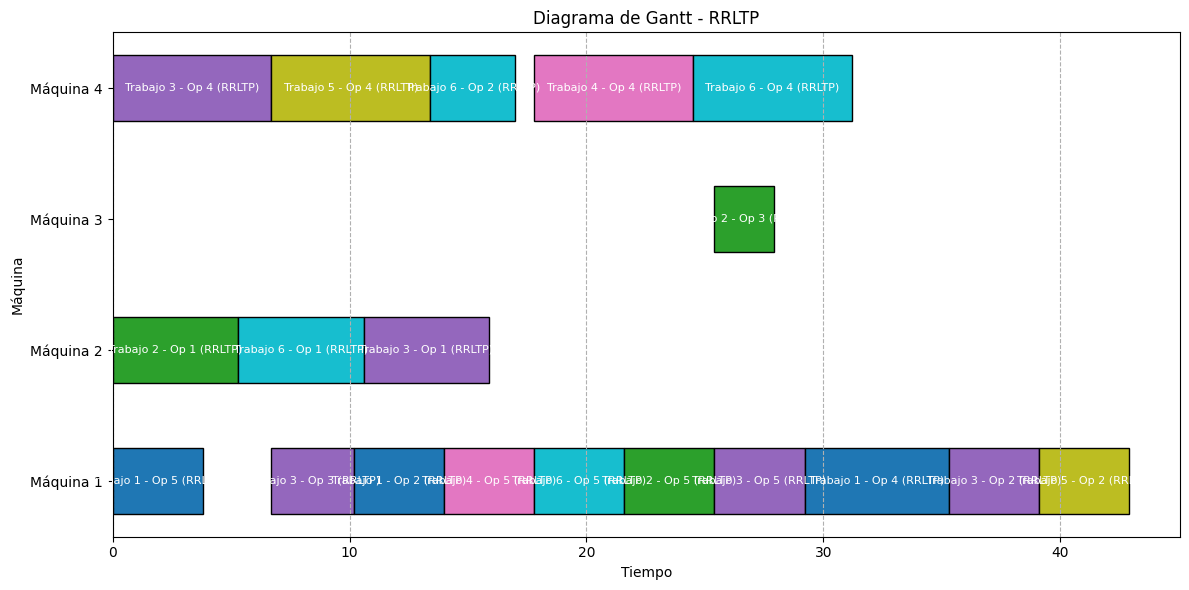

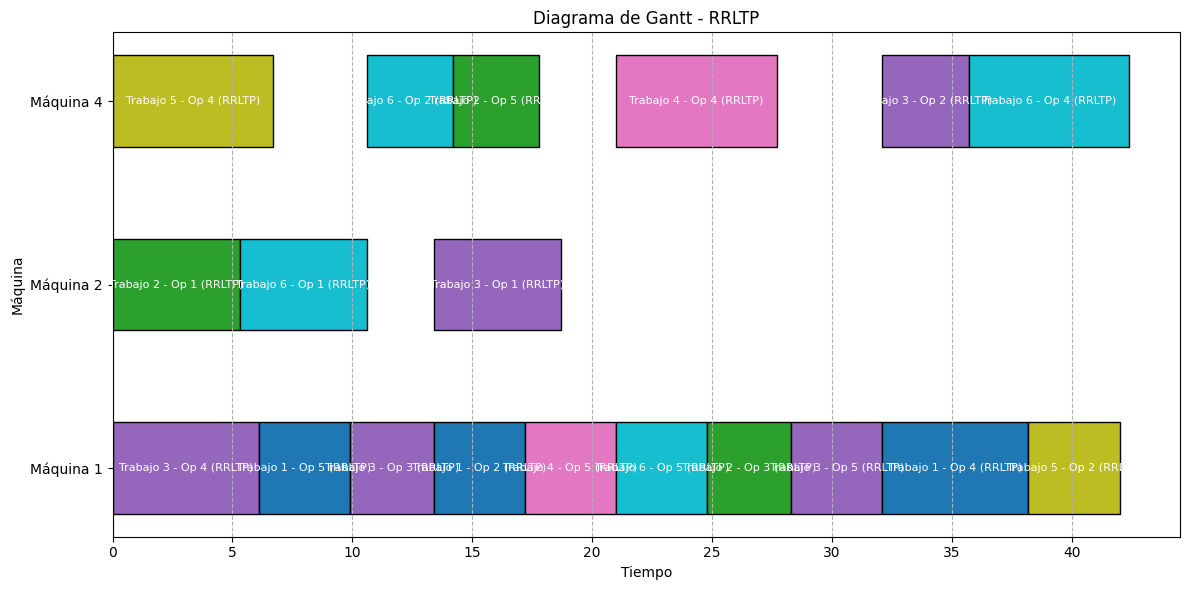

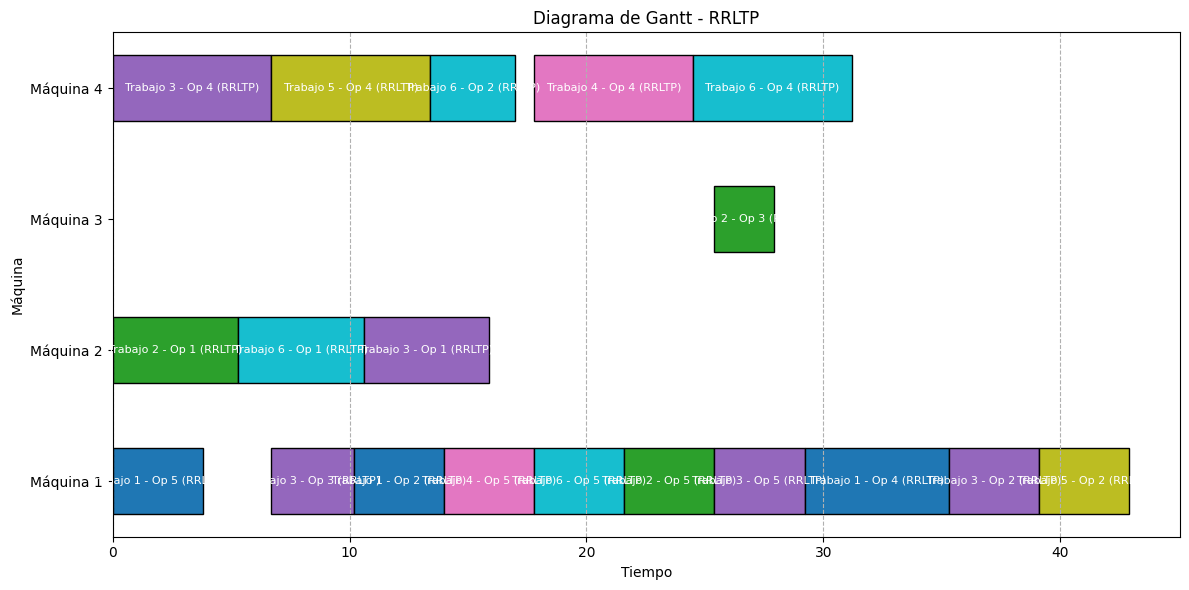

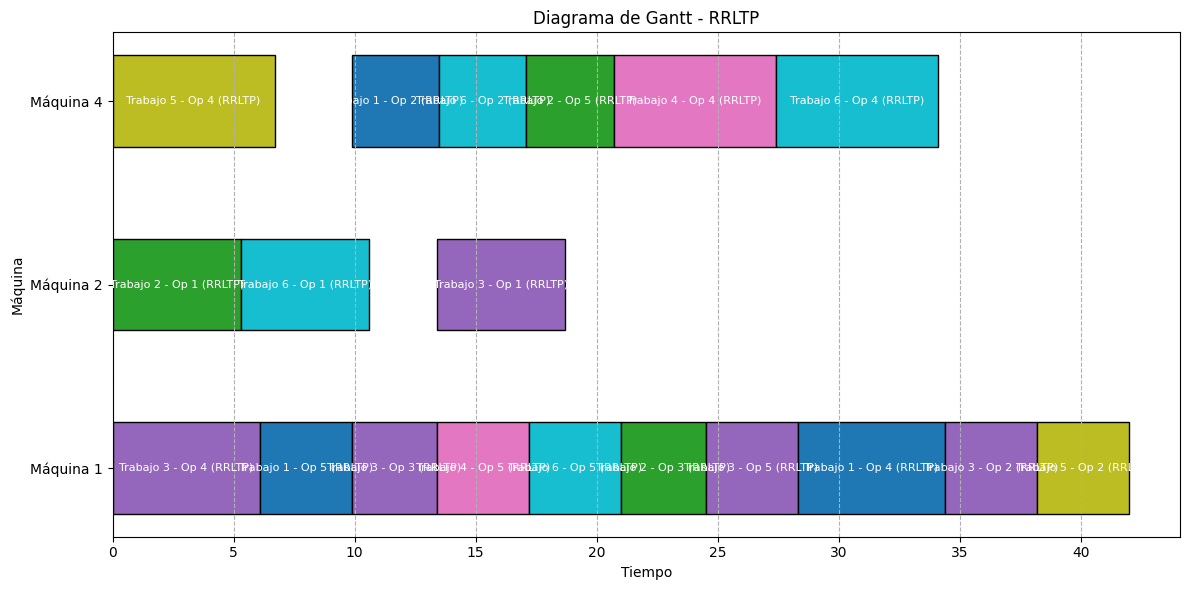

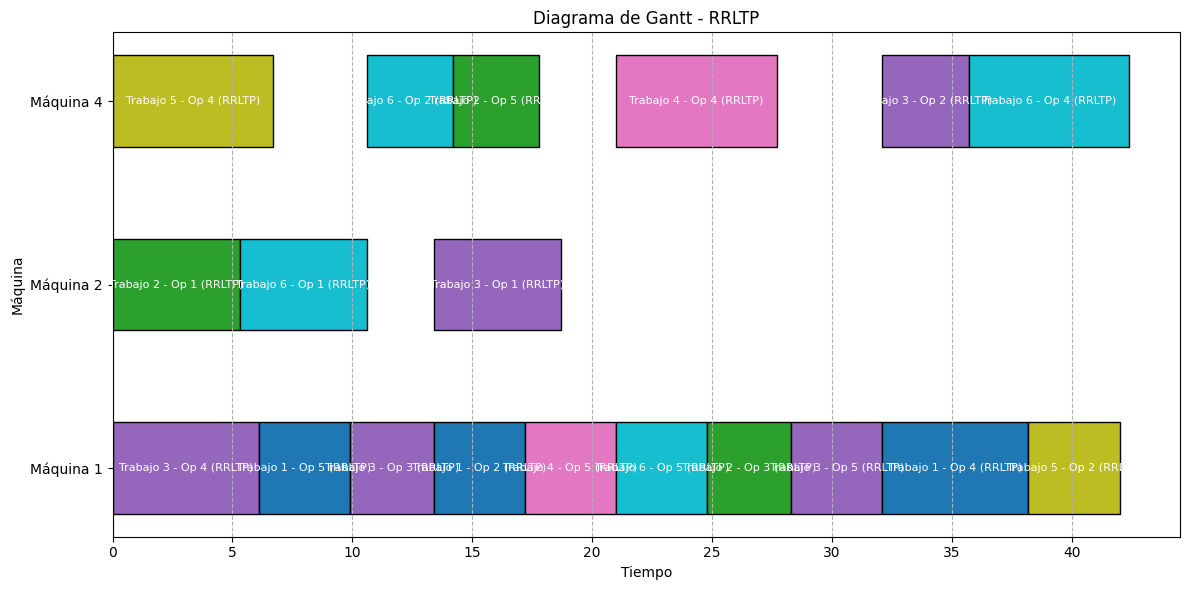

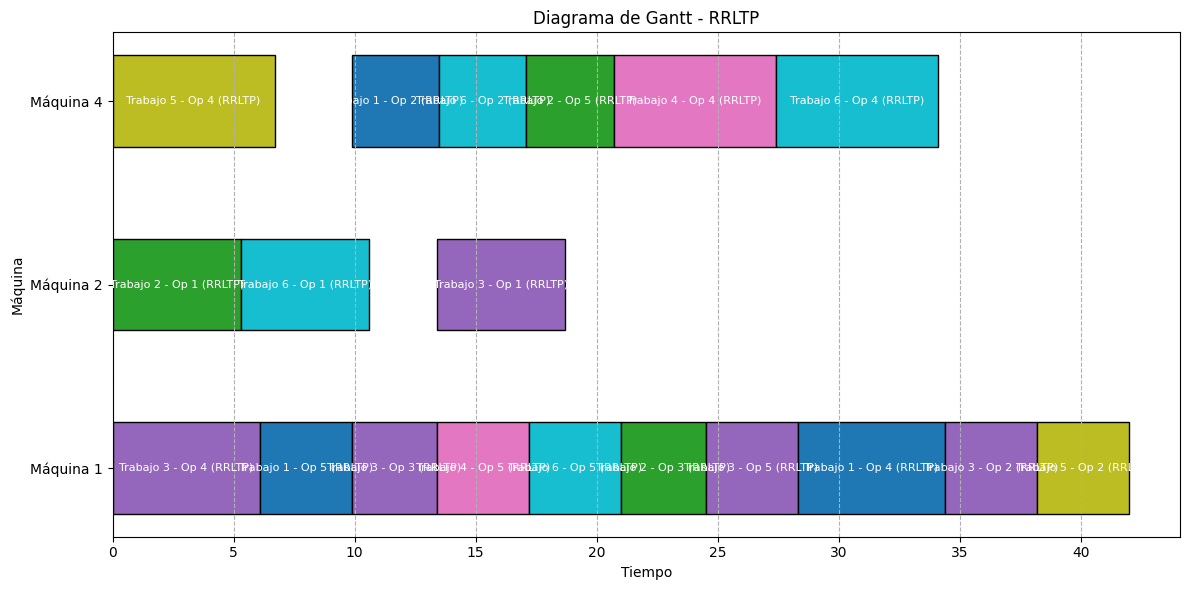

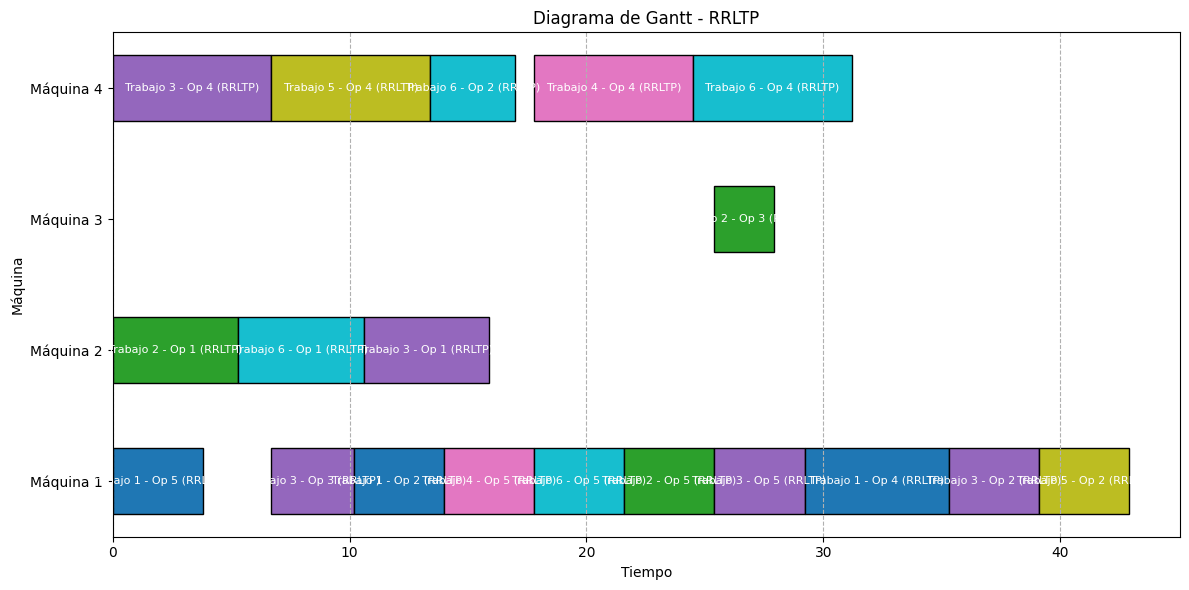

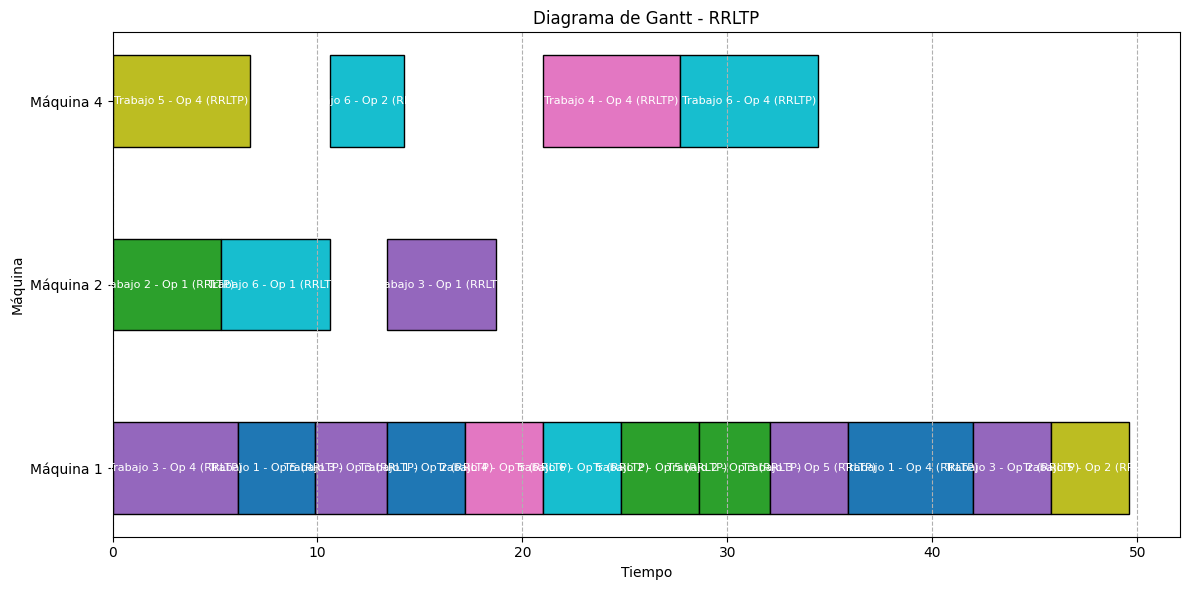

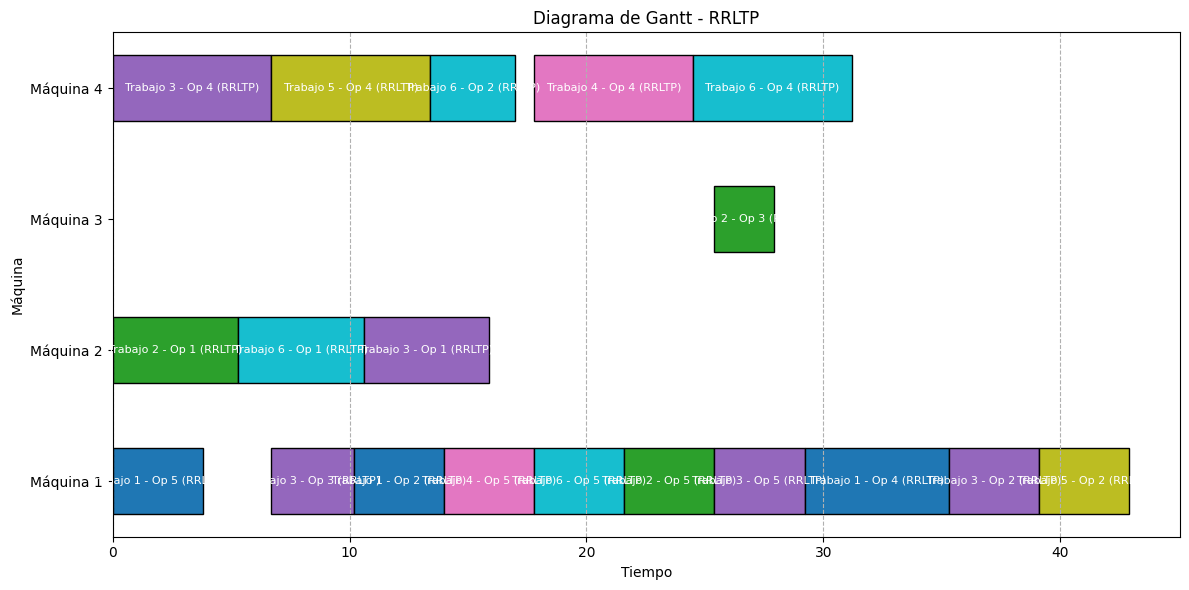

In [ ]:
from pymoo.indicators.hv import HV

def main():

    semilla = 42
    random.seed(semilla)
    np.random.seed(semilla)

    df_energia = pd.read_csv("Energias.csv")
    df_tiempos = pd.read_csv("Tiempos.csv")

    global n_maq
    n_maq = df_tiempos.shape[1]
    global tam
    tam = df_tiempos.shape[0]

    tam_pob = 10
    num_generaciones = 100

    poblacion = Poblacion(tam=tam_pob)#inicializar poblacion y generarla aleatoriamente
    poblacion.evaluarEnergia(df_energia)#evaluar valores objetivo de energia
    poblacion.evaluarTiempo(df_tiempos)#evaluar valores objetivo de energia
    poblacion.pareto_sorting()#asignar nivel de dominancia
    poblacion.graficarfrentes()
    print(f"Generación {0}")
    poblacion.imprimir_poblacion()


    for i in range(1, num_generaciones + 1):
        poblacion.evaluarEnergia(df_energia)#evaluar valores objetivo de energia
        poblacion.evaluarTiempo(df_tiempos)#evaluar valores objetivo de energia
        poblacion.pareto_sorting()#asignar nivel de dominancia
        poblacion.sig_generacion(df_energia, df_tiempos)
        if i % 20 == 0:
            print(f"Generación {i}")
            poblacion.graficarfrentes()
            poblacion.imprimir_poblacion()

            politicas_nombres = ["FIFO", "LTP", "STP", "RRFIFO", "LTPRR", "RRECA"]
            hipervolumenes_por_politica = {}

            for p_idx, politica_nombre in enumerate(politicas_nombres):
                current_policy_points = []
                for individuo in poblacion.individuos:
                    energy_val = individuo.energia[p_idx]
                    time_val = individuo.tiempo[p_idx]
                    if energy_val > 0 and time_val > 0:
                        current_policy_points.append([energy_val, time_val])

                if current_policy_points:
                    current_policy_points = np.array(current_policy_points)
                    ref_point = np.max(current_policy_points, axis=0) * 1.1

                    hv_indicator = HV(ref_point=ref_point)
                    hv_value = hv_indicator(current_policy_points)
                    hipervolumenes_por_politica[politica_nombre] = hv_value
                else:
                    hipervolumenes_por_politica[politica_nombre] = 0.0

            print("\n--- Hipervolúmenes por Política ---")
            for politica, hv_val in hipervolumenes_por_politica.items():
                print(f"{politica}: HV = {hv_val:.2f}")
            print("----------------------------------\n")

        if i % num_generaciones == 0:
            for j in range(tam_pob):
                graficar_gantt(poblacion.individuos[j].cromosoma[4], df_tiempos, 4)


if __name__ == "__main__":
    main()